### Midterm Project
### Heart Disease Classifier

__Description__

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

%matplotlib inline

In [32]:
df = pd.read_csv('heart_cleveland_upload.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [34]:
df.describe().round(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00
mean,54.54,0.68,2.16,131.69,247.35,0.14,1.00,149.60,0.33,1.06,0.60,0.68,0.84,0.46
std,9.05,0.47,0.96,17.76,52.00,0.35,0.99,22.94,0.47,1.17,0.62,0.94,0.96,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,48.00,0.00,2.00,120.00,211.00,0.00,0.00,133.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,56.00,1.00,2.00,130.00,243.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,0.00,0.00
75%,61.00,1.00,3.00,140.00,276.00,0.00,2.00,166.00,1.00,1.60,1.00,1.00,2.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,3.00,2.00,1.00


In [35]:
df.nunique()

age           41
sex            2
cp             4
trestbps      50
chol         152
fbs            2
restecg        3
thalach       91
exang          2
oldpeak       40
slope          3
ca             4
thal           3
condition      2
dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

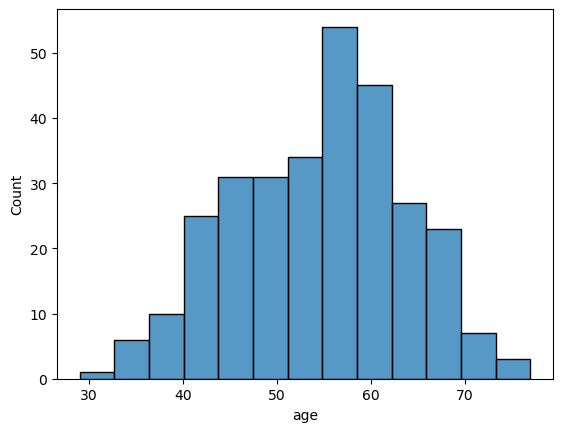

In [48]:
sns.histplot(df.age)

In [36]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical = ['sex', 'fbs', 'exang', 'condition', 'cp', 'restecg', 'slope', 'ca', 'thal']

cat_map_to_string = {
    'sex'       : ['female', 'male'],
    'fbs'       : ['false', 'true'],
    'exang'     : ['no', 'yes'], 
    'condition' : ['no_disease', 'disease'], 
    'cp'        : ["typical_angina", "atypical_angina", "non_anginal_pain", "asymtomatic"], 
    'restecg'   : ['normal', 'st-t_wave_abnormality', 'left_ventricular_hypertrophy'], 
    'slope'     : ['upsloping', 'flat', 'downsloping'], 
    'ca'        : ['zero', 'one', 'two', 'three'], 
    'thal'      : ['normal', 'fixed_defect', 'reversable_defect']
}

In [37]:
for cat in categorical:
    c = cat_map_to_string[cat]
    df[cat] = df[cat].map(lambda x: c[x])

In [38]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,male,typical_angina,160,234,true,left_ventricular_hypertrophy,131,no,0.1,flat,one,normal,no_disease
1,69,female,typical_angina,140,239,false,normal,151,no,1.8,upsloping,two,normal,no_disease
2,66,female,typical_angina,150,226,false,normal,114,no,2.6,downsloping,zero,normal,no_disease
3,65,male,typical_angina,138,282,true,left_ventricular_hypertrophy,174,no,1.4,flat,one,normal,disease
4,64,male,typical_angina,110,211,false,left_ventricular_hypertrophy,144,yes,1.8,flat,zero,normal,no_disease


In [39]:
df.corr()

,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.290476,0.202644,-0.394563,0.197123
trestbps,0.290476,1.000000,0.131536,-0.049108,0.191243
chol,0.202644,0.131536,1.000000,-0.000075,0.038596
thalach,-0.394563,-0.049108,-0.000075,1.000000,-0.347640
oldpeak,0.197123,0.191243,0.038596,-0.347640,1.000000


In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=49)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=49)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.condition == 'disease').astype('int').values
y_val = (df_val.condition == 'disease').astype('int').values
y_test = (df_test.condition == 'disease').astype('int').values

del df_train['condition']
del df_val['condition']
del df_test['condition']

In [41]:
train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [42]:
X_train.shape

(177, 28)

In [50]:
LR = LogisticRegression(random_state=49)
LR.fit(X_train, y_train)

/home/vii/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=49)

In [44]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = LR.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.888

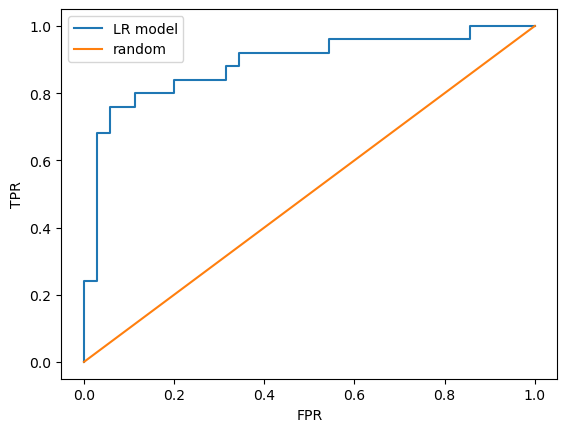

In [51]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.plot(fpr, tpr, label='LR model')
plt.plot([0, 1], [0, 1], label='random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [59]:
max_iter_values = list(range(100, 1001, 100))
scores = []
for max_iter in max_iter_values:
    model = LogisticRegression(max_iter=max_iter, random_state=49)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

/home/vii/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vii/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


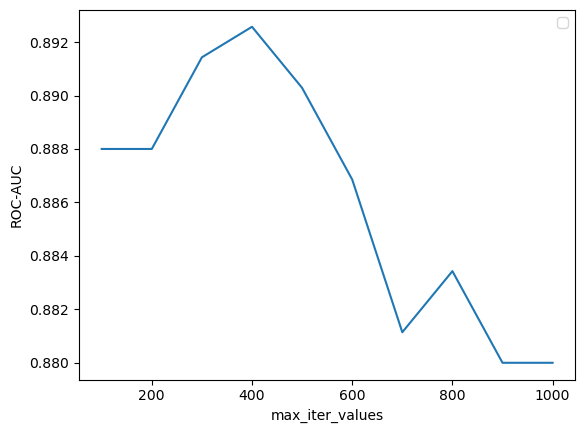

In [60]:
plt.plot(max_iter_values, scores)
plt.xlabel('max_iter_values')
plt.ylabel('ROC-AUC')
plt.legend()

In [63]:
max_iter_values[
    np.argmax(scores)
]

400

_so, rhe max_iter is 

In [58]:
C_values = [0.01, 0.1, 1, 10, 25, 50, 75, 100]
scores = []

for C in C_values:
    model = LogisticRegression(C=C, random_state=49)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

/home/vii/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vii/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


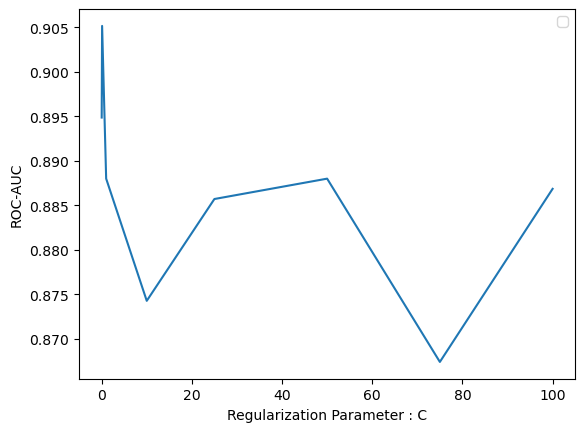

In [56]:
plt.plot(C_values, scores)
plt.xlabel('Regularization Parameter : C')
plt.ylabel('ROC-AUC')
plt.legend()